In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [ ]:
import sys
from pathlib import Path

# allow imports from src/
PROJECT_ROOT = Path("...").resolve()
sys.path.append(str(PROJECT_ROOT))

# import dataloader function
from src.data.dataload import load_csv_folder_to_dataframe

DATA_DIR = PROJECT_ROOT / "data/raw"
PLOTS_DIR = PROJECT_ROOT / "outputs/plots"

In [2]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [3]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [4]:
# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Stadt Ludwigsburg"] # change domain name here for other towns
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Stadt Ludwigsburg


{'Aldinger Straße': (np.float64(48.88313941250021),
  np.float64(9.21056628227234)),
 'Alleenstraße': (np.float64(48.89318853889096),
  np.float64(9.192943238836945)),
 'Bismarckstraße': (np.float64(48.89903941796738),
  np.float64(9.181308746337892)),
 'Bottwartalstraße': (np.float64(48.90348261474315),
  np.float64(9.198206663131716)),
 'Friedrich-Ebert-Straße': (np.float64(48.89303342189355),
  np.float64(9.206430315971376)),
 'Fuchshof': (np.float64(48.89027528881407), np.float64(9.219911098480226)),
 'Kesseläcker (Verl. Nussackerweg)': (np.float64(48.90177238337826),
  np.float64(9.17190492153168)),
 'Königinallee': (np.float64(48.88483617136294),
  np.float64(9.206655621528627)),
 'Marbacher Straße - Favoritepark': (np.float64(48.9024917455577),
  np.float64(9.195814132690431)),
 'Marbacher Straße - Neckarbrücke': (np.float64(48.90732601393936),
  np.float64(9.2190957069397)),
 'Schlieffenstraße': (np.float64(48.89376701735068),
  np.float64(9.164308905601503)),
 'Schlossstraße':

In [5]:
# we need a reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

dist_matrix_euclid

,Aldinger Straße,Alleenstraße,Bismarckstraße,Bottwartalstraße,Friedrich-Ebert-Straße,Fuchshof,Kesseläcker (Verl. Nussackerweg),Königinallee,Marbacher Straße - Favoritepark,Marbacher Straße - Neckarbrücke,Schlieffenstraße,Schlossstraße,Seestraße,Solitudeallee,Zugwiesen
Aldinger Straße,0.000000,1705.381275,2774.952979,2435.832551,1140.954354,1047.030878,3504.357035,342.527365,2406.989944,2760.761910,3582.100101,2246.173238,1624.701483,2035.832594,3663.942045
Alleenstraße,1705.381275,0.000000,1070.815305,1207.589110,986.098428,1997.871897,1810.075712,1366.529077,1055.543878,2475.139669,2094.247491,787.487042,444.021267,1305.229196,3943.838244
Bismarckstraße,2774.952979,1070.815305,0.000000,1330.428182,1954.126526,2985.484878,751.622552,2434.676895,1127.736687,2911.971697,1374.086010,949.574376,1257.033991,1724.040943,4509.879807
Bottwartalstraße,2435.832551,1207.589110,1330.428182,0.000000,1308.211101,2162.000587,1932.121138,2163.430477,206.712537,1585.729357,2703.284311,467.154237,1650.634493,2487.381649,3193.902399
Friedrich-Ebert-Straße,1140.954354,986.098428,1954.126526,1308.211101,0.000000,1032.106799,2704.514697,911.641469,1307.059391,1839.296733,3080.287271,1200.956477,1223.879599,2027.824892,3108.571187
Fuchshof,1047.030878,1997.871897,2985.484878,2162.000587,1032.106799,0.000000,3735.004073,1142.269441,2224.495183,1896.890913,4083.195847,2182.690361,2146.764146,2819.032592,2619.434911
Kesseläcker (Verl. Nussackerweg),3504.357035,1810.075712,751.622552,1932.121138,2704.514697,3735.004073,0.000000,3162.289776,1749.667591,3504.629795,1049.155697,1636.914720,1928.594241,2173.832732,5119.213927
Königinallee,342.527365,1366.529077,2434.676895,2163.430477,911.641469,1142.269441,3162.289776,0.000000,2117.150206,2660.978699,3251.060902,1939.212599,1285.940507,1755.128197,3703.277122
Marbacher Straße - Favoritepark,2406.989944,1055.543878,1127.736687,206.712537,1307.059391,2224.495183,1749.667591,2117.150206,0.000000,1784.827715,2499.118556,279.227796,1493.217741,2312.100857,3388.338737
Marbacher Straße - Neckarbrücke,2760.761910,2475.139669,2911.971697,1585.729357,1839.296733,1896.890913,3504.629795,2660.978699,1784.827715,0.000000,4279.468860,1985.725727,2876.160053,3748.513520,1615.418057


In [6]:
# compute median of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.median(lats)

lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.median(lons)

# set median as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and 6km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=6000, network_type='bike')

In [7]:
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [8]:
# now name the nodes and compute shortest distance by bike
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


distance between Aldinger Straße and Alleenstraße: 2097.2 m
distance between Aldinger Straße and Bismarckstraße: 3268.8 m
distance between Aldinger Straße and Bottwartalstraße: 3022.5 m
distance between Aldinger Straße and Friedrich-Ebert-Straße: 1575.1 m
distance between Aldinger Straße and Fuchshof: 1696.0 m
distance between Aldinger Straße and Kesseläcker (Verl. Nussackerweg): 4200.8 m
distance between Aldinger Straße and Königinallee: 368.9 m
distance between Aldinger Straße and Marbacher Straße - Favoritepark: 2983.1 m
distance between Aldinger Straße and Marbacher Straße - Neckarbrücke: 3494.3 m
distance between Aldinger Straße and Schlieffenstraße: 3948.0 m
distance between Aldinger Straße and Schlossstraße: 2772.7 m
distance between Aldinger Straße and Seestraße: 2094.3 m
distance between Aldinger Straße and Solitudeallee: 2730.0 m
distance between Aldinger Straße and Zugwiesen: 4437.7 m
distance between Alleenstraße and Bismarckstraße: 1500.5 m
distance between Alleenstraße an

In [9]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line, do not recommend it for towns with many sites though)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Stadt Mannheim: 14 counter
- Stadt Freiburg: 10 counter
- Stadt Reutlingen: 7 counter
- Ravensburg Tws Gmbh & Co. Kg: 7 counter
- Stadt Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [10]:
# pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,Aldinger Straße,Alleenstraße,Bismarckstraße,Bottwartalstraße,Friedrich-Ebert-Straße,Fuchshof,Kesseläcker (Verl. Nussackerweg),Königinallee,Marbacher Straße - Favoritepark,Marbacher Straße - Neckarbrücke,Schlieffenstraße,Schlossstraße,Seestraße,Solitudeallee,Zugwiesen
counter_site,,,,,,,,,,,,,,,
Aldinger Straße,41946,41908,41303,41625,41451,41906,41908,41495,41908,41910,40462,41572,41661,41534,41610
Alleenstraße,41908,68819,41303,41625,41451,42843,41908,41457,67656,57732,41685,41572,42336,41524,41572
Bismarckstraße,41303,41303,41304,41301,41277,41301,41303,41303,41303,41303,39857,41303,41056,40891,41303
Bottwartalstraße,41625,41625,41301,41625,41451,41625,41625,41455,41625,41625,40181,41570,41378,41213,41570
Friedrich-Ebert-Straße,41451,41451,41277,41451,41451,41451,41451,41431,41451,41451,40007,41451,41204,41039,41451
Fuchshof,41906,42843,41301,41625,41451,42843,41906,41455,42843,42843,41399,41570,42334,41522,41570
Kesseläcker (Verl. Nussackerweg),41908,41908,41303,41625,41451,41906,41908,41457,41908,41908,40462,41572,41661,41496,41572
Königinallee,41495,41457,41303,41455,41431,41455,41457,41495,41457,41459,40011,41457,41210,41083,41495
Marbacher Straße - Favoritepark,41908,67656,41303,41625,41451,42843,41908,41457,69650,57732,41685,41572,42336,41524,41572


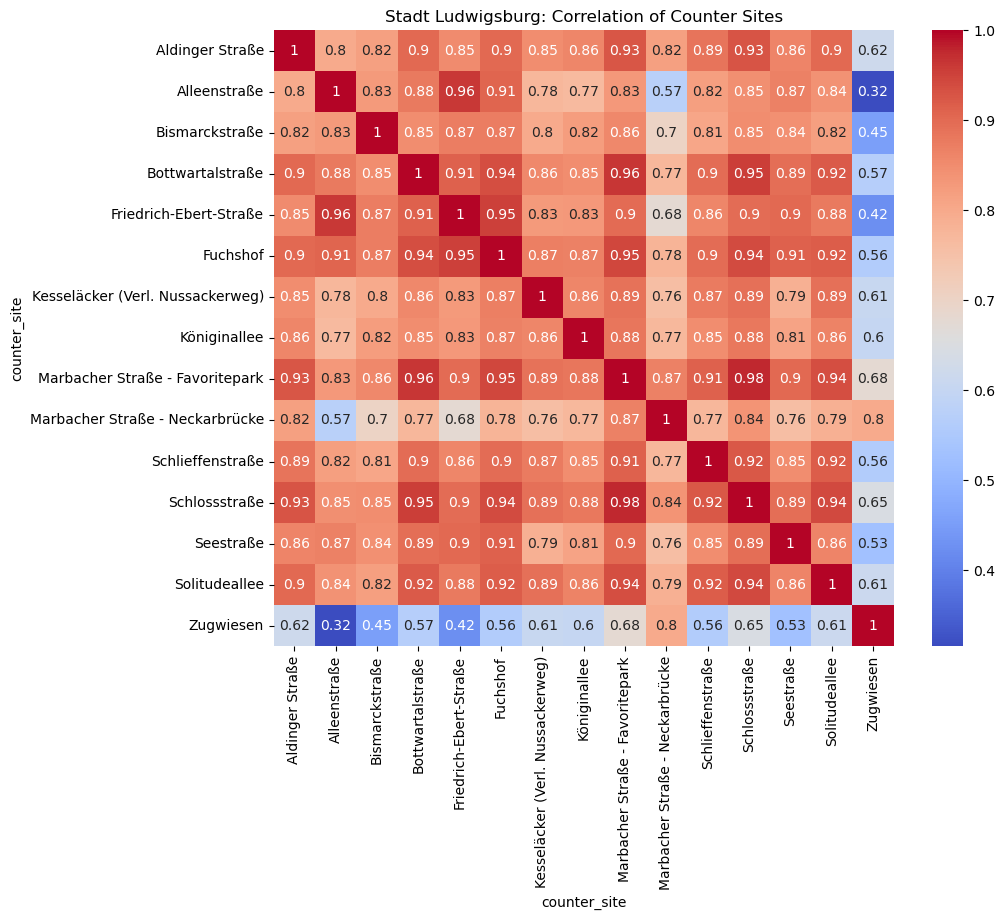

In [11]:
# compute correlation matrix and plot heatmap
# this shows correlation of counter sites based on their counts
corr_matrix = df_domain_pivot.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

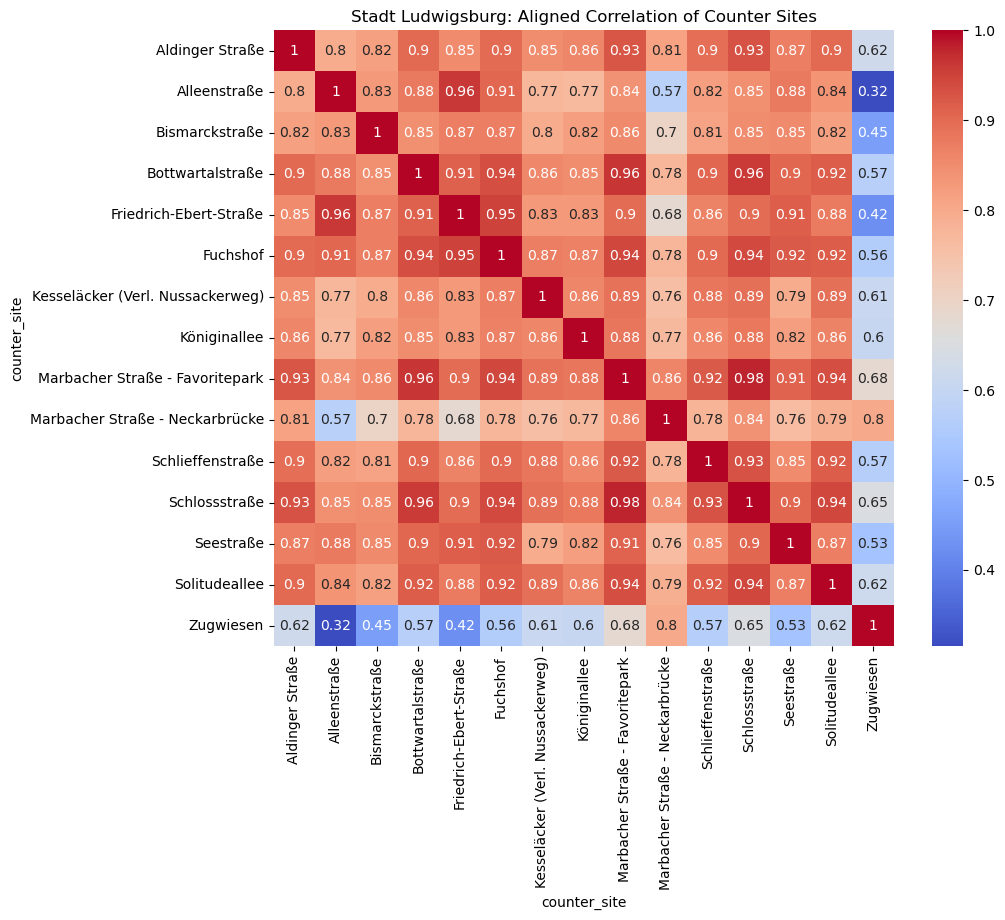

In [12]:
# correlation matrix for just times where all sites have data
# maybe more meaningful, still not sure
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

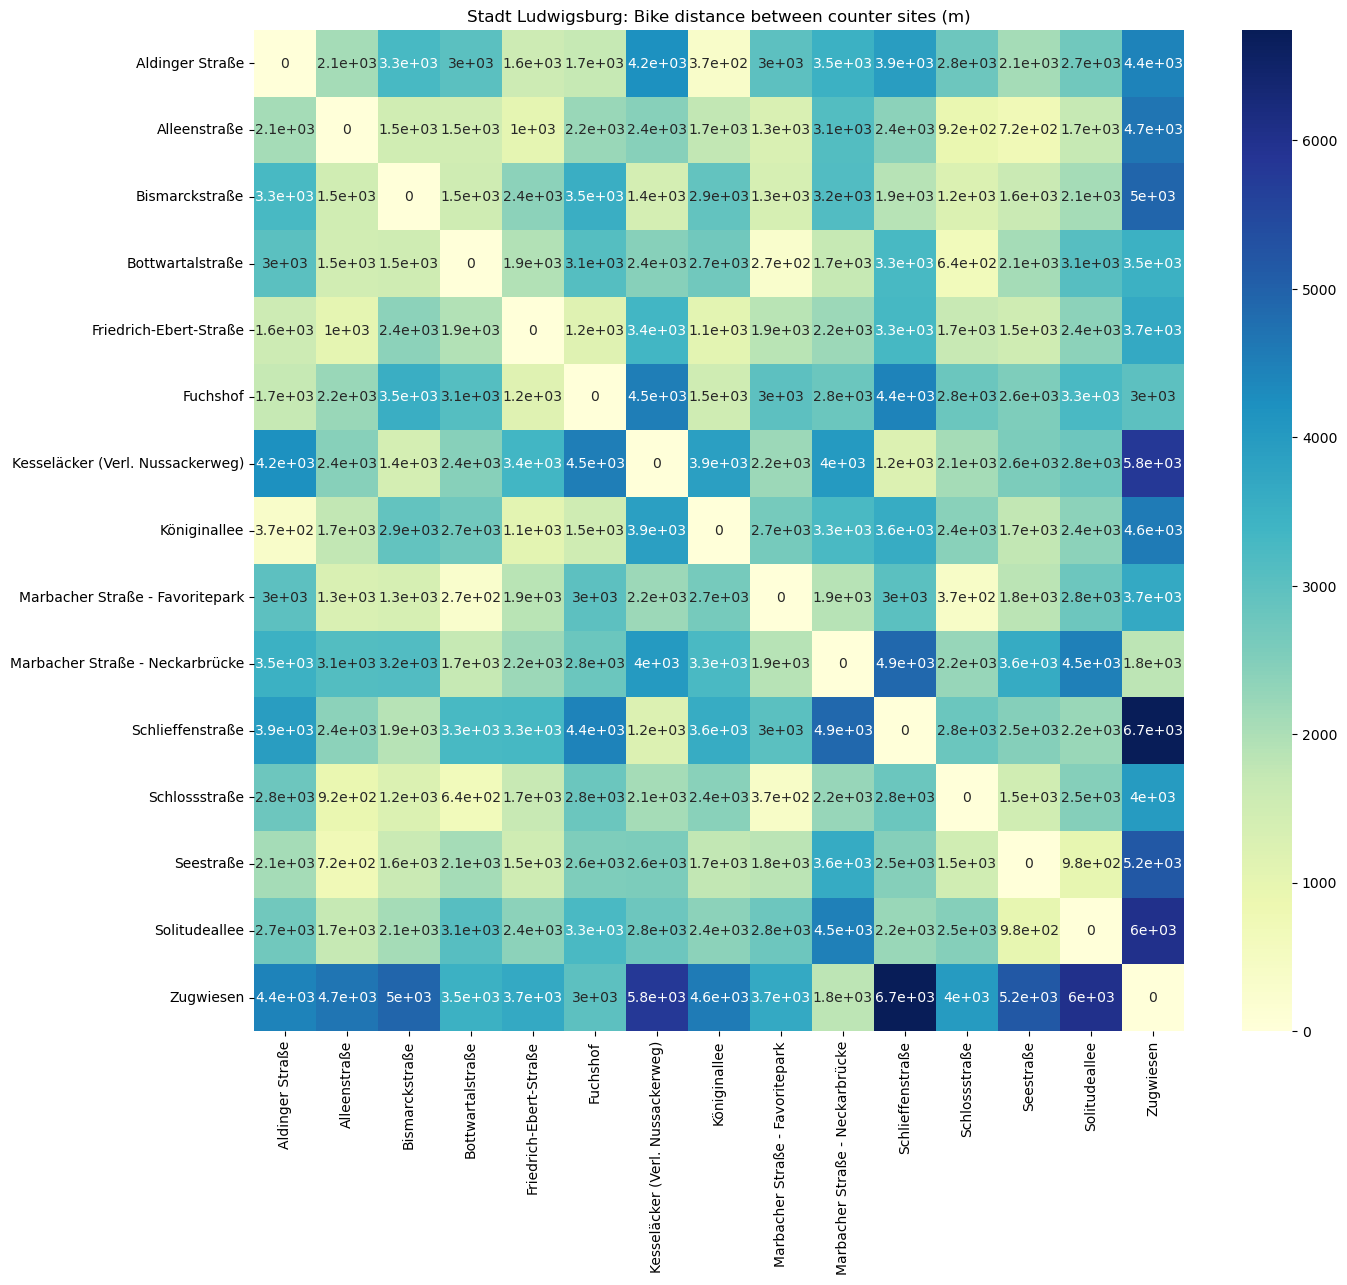

In [13]:
# now we want matrices for distances
# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Bike distance between counter sites (m)")
plt.show()  

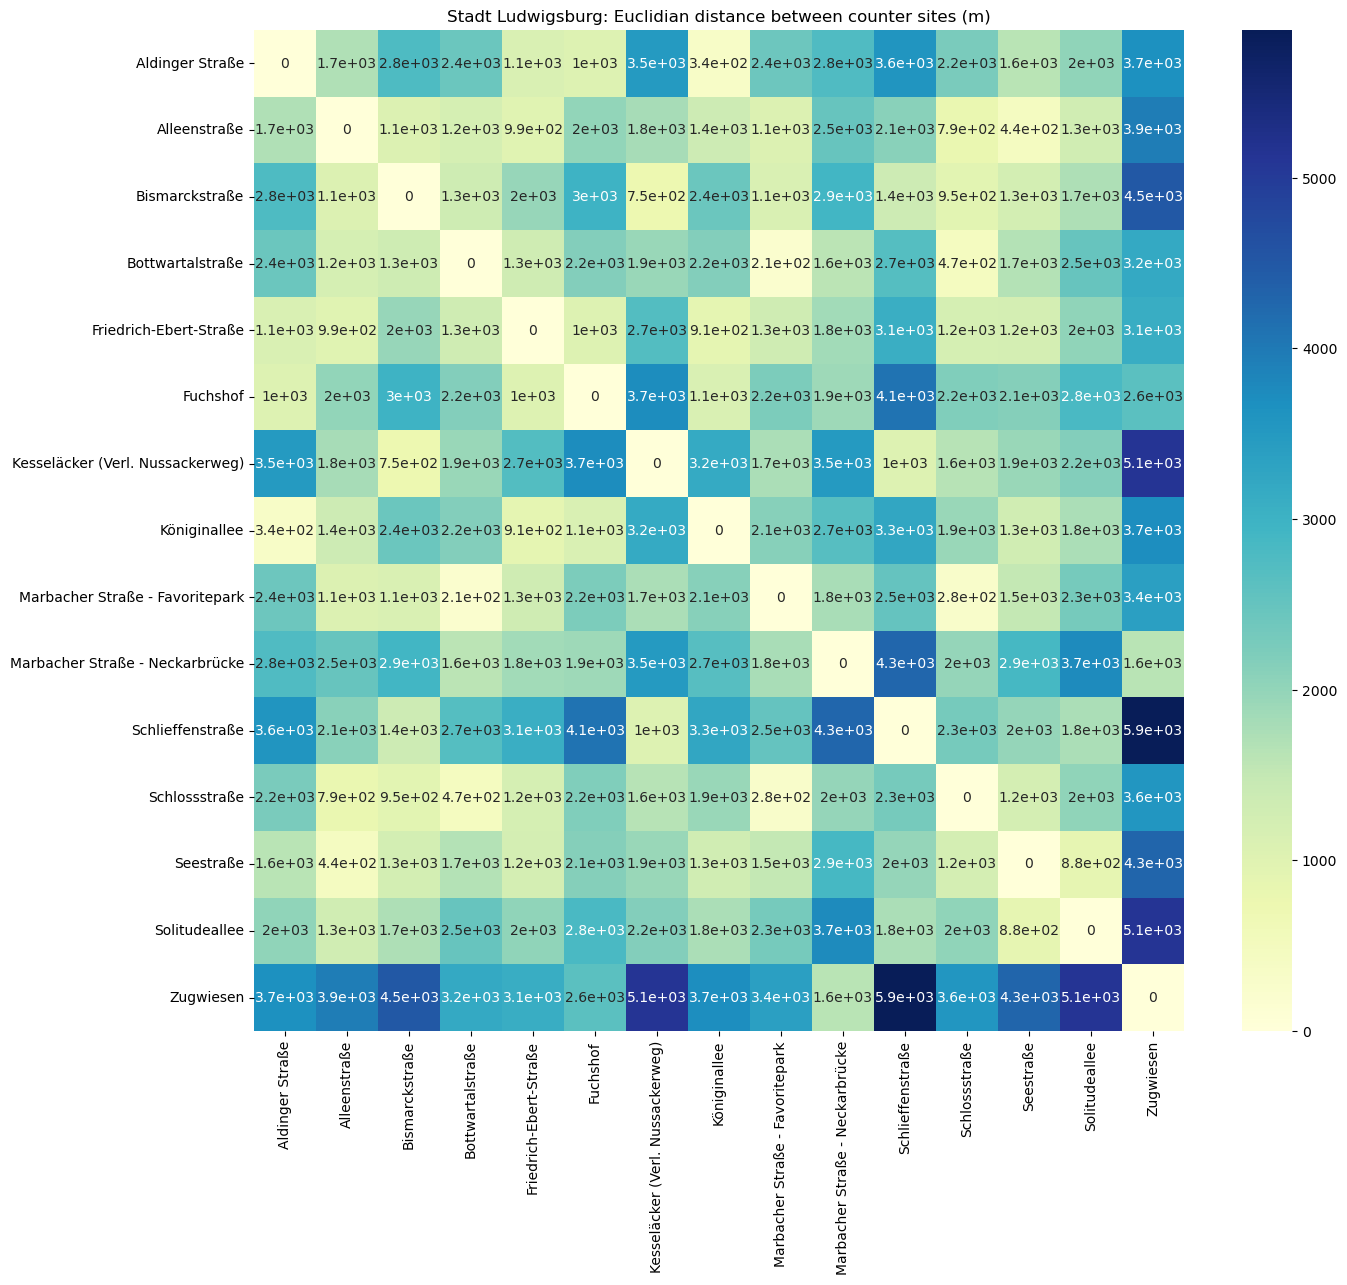

In [14]:
# now again for euclidian distances (we computed matrix already above)
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix_euclid.astype(float), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Euclidian distance between counter sites (m)")
plt.show()

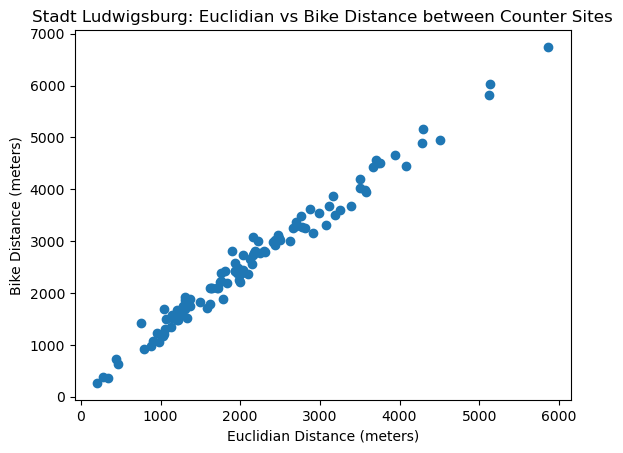

In [15]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidian_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Bike Distance (meters)")
plt.title(f"{title_domain}: Euclidian vs Bike Distance between Counter Sites")
plt.show()

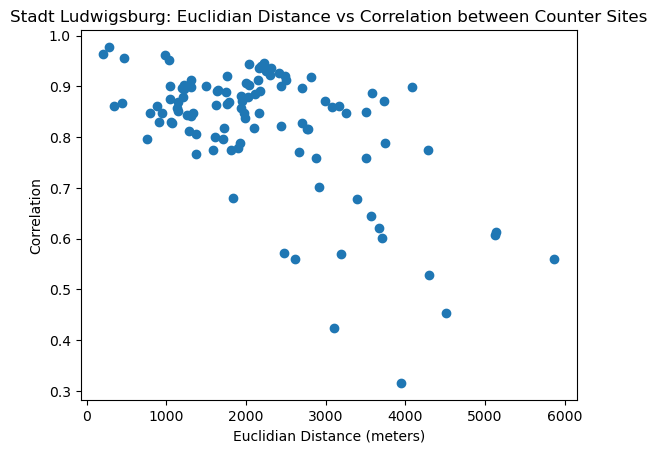

In [16]:
# euclidian distance vs correlation plot
# using euclidian distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Euclidian Distance vs Correlation between Counter Sites")
plt.show()

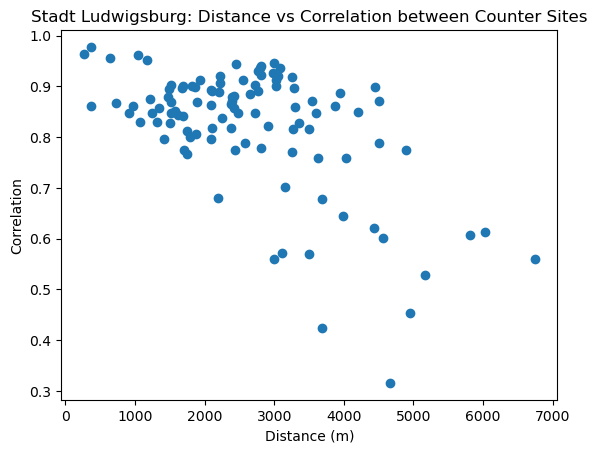

In [17]:
# distance vs correlation plot
# using bike distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Correlation between Counter Sites")
plt.show()

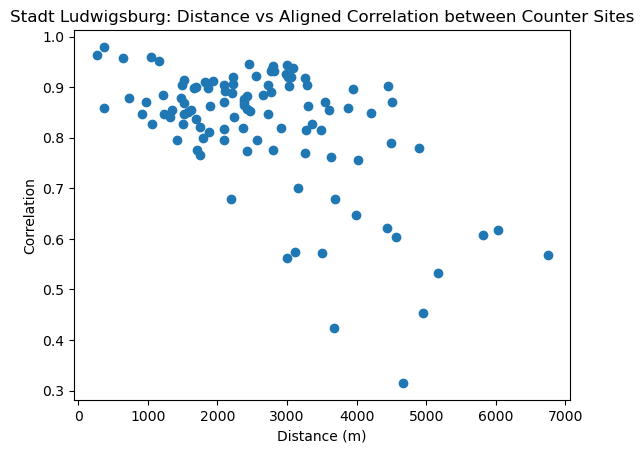

In [18]:
# distance vs correlation plot
# using bike distance and aligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Aligned Correlation between Counter Sites")
plt.show()

In [19]:
################################################
# REGRESSION MODELING - SETUP                  #
################################################

import importlib
import regression_utils
importlib.reload(regression_utils)

from regression_utils import train_model

# Load city data with features
df_city = pd.read_csv('df_features.csv')
df_city = df_city[df_city['domain_name'] == title_domain].copy()

print(f"Loaded {len(df_city):,} hourly records for {title_domain}")
print(f"{df_city['counter_site'].nunique()} stations")
print(f"regression_utils.py reloaded")

Loaded 697,540 hourly records for Stadt Ludwigsburg
15 stations
regression_utils.py reloaded


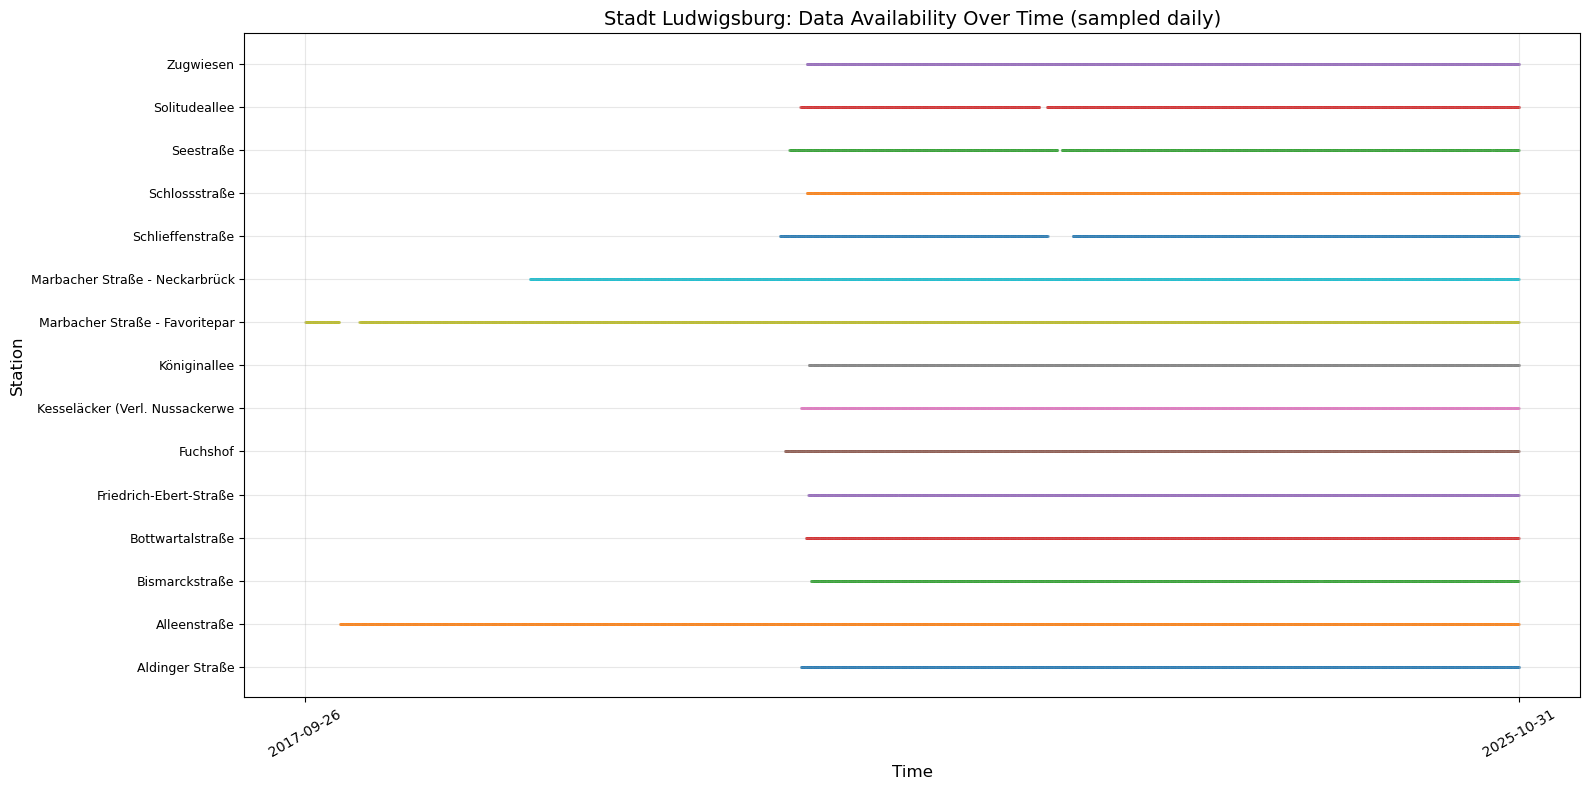


Data Availability Summary:
Total time range: 2017-09-26 22:00:00+00:00 to 2025-10-31 21:00:00+00:00
Total timestamps: 70,852

Timestamps with ALL stations: 39,394 (55.6%)

Per-station coverage:
  Aldinger Straße                           59.2%
  Alleenstraße                              97.1%
  Bismarckstraße                            58.3%
  Bottwartalstraße                          58.7%
  Friedrich-Ebert-Straße                    58.5%
  Fuchshof                                  60.5%
  Kesseläcker (Verl. Nussackerweg)          59.1%
  Königinallee                              58.6%
  Marbacher Straße - Favoritepark           98.3%
  Marbacher Straße - Neckarbrücke           81.5%
  Schlieffenstraße                          58.8%
  Schlossstraße                             58.7%
  Seestraße                                 59.8%
  Solitudeallee                             58.7%
  Zugwiesen                                 58.7%

Sanity check:
Start window: 2017-09-26 22:00:00+00:00 

In [ ]:
################################################
# DATA AVAILABILITY VISUALIZATION              #
################################################

# Create pivot table to see when each station has data
df_pivot_avail = df_city.pivot_table(
    index='iso_timestamp',
    columns='counter_site',
    values='channels_all',
    aggfunc='count'
)

# Convert index to datetime to avoid categorical axis issues
df_pivot_avail.index = pd.to_datetime(df_pivot_avail.index)

# Convert to binary (1 = has data, 0 = missing)
df_avail_binary = df_pivot_avail.notna().astype(int)

# Sample data for visualization (every 24 hours to avoid overplotting)
df_sample = df_avail_binary.iloc[::24]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
ax.set_facecolor("white")
fig.patch.set_facecolor("white")

for i, station in enumerate(df_sample.columns):
    # Create line at y=i when data exists
    times = df_sample.index[df_sample[station] == 1]
    if len(times) > 0:
        ax.scatter(times, [i] * len(times), s=1, alpha=0.5)

# y-axis labels
ax.set_yticks(range(len(df_sample.columns)))
ax.set_yticklabels([s[:30] for s in df_sample.columns], fontsize=9)

# x-axis: ensure full time range is shown
start = df_avail_binary.index.min()
end = df_avail_binary.index.max()
#ax.set_xlim(start, end)

# Show start and end timestamps as tick labels
ax.set_xticks([start, end])
ax.set_xticklabels(
    [start.strftime("%Y-%m-%d"), end.strftime("%Y-%m-%d")],
    rotation=30
)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Station', fontsize=12)
ax.set_title(f'{title_domain}: Data Availability Over Time (sampled daily)', fontsize=14)
ax.grid(True, alpha=0.3)
plt.tight_layout()
# safe figure named after city 
# # in directory /plots
plt.savefig(os.join.path(PLOTS_DIR, 'distcorr/data_availability_{title_domain}.png'), dpi=300)
plt.show()

# Show statistics
print(f"\nData Availability Summary:")
print(f"Total time range: {df_avail_binary.index.min()} to {df_avail_binary.index.max()}")
print(f"Total timestamps: {len(df_avail_binary):,}")
print(f"\nTimestamps with ALL stations: {df_avail_binary.all(axis=1).sum():,} "
      f"({df_avail_binary.all(axis=1).sum()/len(df_avail_binary)*100:.1f}%)")
print(f"\nPer-station coverage:")
for station in df_avail_binary.columns:
    coverage = df_avail_binary[station].sum() / len(df_avail_binary) * 100
    print(f"  {station[:40]:40} {coverage:5.1f}%")

# --- Sanity check: first & last 7 days ---

# Full range
first_ts = df_avail_binary.index.min()
last_ts  = df_avail_binary.index.max()

# Window definitions
start_window_end = first_ts + pd.Timedelta(days=7)
end_window_start = last_ts  - pd.Timedelta(days=7)

start_window = df_avail_binary[(df_avail_binary.index >= first_ts) &
                               (df_avail_binary.index <= start_window_end)]

end_window = df_avail_binary[df_avail_binary.index >= end_window_start]

# Active if at least one "1" appears in that window
active_start = list(start_window.columns[start_window.sum(axis=0) > 0])
inactive_start = list(start_window.columns[start_window.sum(axis=0) == 0])

active_end = list(end_window.columns[end_window.sum(axis=0) > 0])
inactive_end = list(end_window.columns[end_window.sum(axis=0) == 0])

print("\nSanity check:")
print(f"Start window: {first_ts} → {start_window_end}")
print(f"  Active stations in first 7 days:   {len(active_start)}")
print(f"  Inactive stations in first 7 days: {len(inactive_start)}")

print(f"\nEnd window:   {end_window_start} → {last_ts}")
print(f"  Active stations in last 7 days:    {len(active_end)}")
print(f"  Inactive stations in last 7 days:  {len(inactive_end)}")

In [21]:
################################################
# TRAIN MODELS FOR ALL STATIONS               #
################################################

all_results = []

for station_idx, station in enumerate(sites1, 1):
    print(f"\n[{station_idx}/{len(sites1)}] {station}")
    
    # Get station data
    df_station = df_city[df_city['counter_site'] == station].copy()
    df_station = df_station.dropna(subset=['channels_all'])
    df_station = df_station.sort_values('iso_timestamp')
    
    # Skip if insufficient data
    if len(df_station) < 1000:
        print(f"    ⊗ Skipped - only {len(df_station)} records")
        continue
    
    # Train model (prints data info internally)
    results, model, features = train_model(df_station, station, df_city)
    
    # Format feature names
    temporal_str = ', '.join(results['temporal_features'])
    weather_str = ', '.join(results['weather_features']) if results['weather_features'] else 'none'
    
    all_results.append(results)
    
    print(f"    Features: {temporal_str} + {weather_str} + {results['n_stations']} station counts = {results['n_features']} total")
    print(f"    Test R² = {results['test_r2']:.4f} | RMSE = {results['test_rmse']:.2f}")

# Create summary DataFrame
results_df = pd.DataFrame(all_results)

print(f"\n{'='*70}")
print(f"SUMMARY - {title_domain}")
print(f"{'='*70}")
print(f"\nAverage Test R²:   {results_df['test_r2'].mean():.4f} ± {results_df['test_r2'].std():.4f}")
print(f"Average Test RMSE: {results_df['test_rmse'].mean():.2f} ± {results_df['test_rmse'].std():.2f}")
print(f"Average Test MAE:  {results_df['test_mae'].mean():.2f} ± {results_df['test_mae'].std():.2f}")

# Print results as markdown table
print(f"\n## Results Table\n")
print("| Station | Test R² | RMSE | MAE | Features |")
print("|---------|---------|------|-----|----------|")
for _, row in results_df.iterrows():
    print(f"| {row['station'][:30]} | {row['test_r2']:.4f} | {row['test_rmse']:.2f} | {row['test_mae']:.2f} | {row['n_features']} |")

# Save results
results_df.to_csv(f'regression_results_{title_domain.replace(" ", "_")}.csv', index=False)
print(f"\n✓ Saved: regression_results_{title_domain.replace(' ', '_')}.csv")


[1/15] Aldinger Straße
    Complete coverage: 39,394/70,852 hours (55.6%)
    Time frame: 2021-02-09 10:00:00+00:00 to 2025-10-31 01:00:00+00:00 (1724 days, 39,394 hours)
    Features: hour, day_of_week, month + none + 14 station counts = 17 total
    Test R² = 0.8762 | RMSE = 5.31

[2/15] Alleenstraße
    Complete coverage: 39,394/70,852 hours (55.6%)
    Time frame: 2021-02-09 10:00:00+00:00 to 2025-10-31 01:00:00+00:00 (1724 days, 39,394 hours)
    Features: hour, day_of_week, month + none + 14 station counts = 17 total
    Test R² = 0.9382 | RMSE = 31.82

[3/15] Bismarckstraße
    Complete coverage: 39,394/70,852 hours (55.6%)
    Time frame: 2021-02-09 10:00:00+00:00 to 2025-10-31 01:00:00+00:00 (1724 days, 39,394 hours)
    Features: hour, day_of_week, month + none + 14 station counts = 17 total
    Test R² = 0.8134 | RMSE = 11.14

[4/15] Bottwartalstraße
    Complete coverage: 39,394/70,852 hours (55.6%)
    Time frame: 2021-02-09 10:00:00+00:00 to 2025-10-31 01:00:00+00:00 (17